# Travel Time Prediction Model Training for Udupi Delivery Routes

In [84]:
pip install python-dotenv

  Obtaining dependency information for python-dotenv from https://files.pythonhosted.org/packages/1e/18/98a99ad95133c6a6e2005fe89faedf294a748bd5dc803008059409ac9b1e/python_dotenv-1.1.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import requests
import datetime
from typing import List, Dict, Any, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

In [106]:
# ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [107]:
import os
from dotenv import load_dotenv
import numpy as np

In [92]:
# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f" XGBoost version: {xgb.__version__}")

All libraries imported successfully!
 XGBoost version: 3.0.2


### CONFIGURATION AND SETUP

In [98]:
# Load environment variables from .env file
cwd = os.getcwd()
env_path = os.path.join(cwd, ".env")
load_dotenv(dotenv_path='../frontend/.env')

# Configuration using environment variables
CONFIG = {
    'GOOGLE_API_KEY': os.getenv("NEXT_PUBLIC_GOOGLE_MAPS_API_KEY"),
    'WEATHER_API_KEY': os.getenv("WEATHER_API_KEY"),
    'USE_SIMULATED_DATA': False,  # Set to True if you want to use simulated lat/long
    'TRAINING_SAMPLES_PER_ROUTE': 50,
    'RANDOM_SEED': 42
}

# Set random seeds for reproducibility
np.random.seed(CONFIG['RANDOM_SEED'])

# Print config summary
print("Configuration loaded:")
for key, value in CONFIG.items():
    if 'API_KEY' in key:
        print(f"   {key}: {'Set' if value else 'Not Set'}")
    else:
        print(f"   {key}: {value}")


Configuration loaded:
   GOOGLE_API_KEY: Set
   WEATHER_API_KEY: Set
   USE_SIMULATED_DATA: False
   TRAINING_SAMPLES_PER_ROUTE: 50
   RANDOM_SEED: 42


### DATA COLLECTION FUNCTIONS

In [56]:
def get_google_maps_travel_time(origin_lat: float, origin_lng: float,
                               dest_lat: float, dest_lng: float,
                               departure_time: datetime.datetime,
                               api_key: Optional[str] = None) -> Optional[float]:
    """Get travel time from Google Maps Distance Matrix API."""
    
    if not api_key or CONFIG['USE_SIMULATED_DATA']:
        
        # Simulate realistic travel times for Udupi
        distance_deg = np.sqrt((origin_lat - dest_lat)**2 + (origin_lng - dest_lng)**2)
        distance_km = distance_deg * 111  # Rough conversion to km
        
        # Base travel time (assuming 25 km/h average speed in city)
        base_time = (distance_km / 25) * 60  # minutes
        
        # Add time-based factors
        hour = departure_time.hour
        day_of_week = departure_time.weekday()
        
        # Rush hour multiplier
        if (7 <= hour <= 9) or (17 <= hour <= 19):
            time_multiplier = 1.5
        elif (22 <= hour <= 6):  # Night time
            time_multiplier = 0.8
        else:
            time_multiplier = 1.0
        
        # Weekend factor
        if day_of_week >= 5:  # Weekend
            time_multiplier *= 0.9
        
        # Weather factor (random)
        weather_factor = np.random.uniform(0.9, 1.3)
        
        # Package weight factor (added for delivery format)
        # Assuming average weight is 3kg, with max impact of ±15%
        weight_factor = 1.0  # Will be set in create_features()
        
        # Calculate final time with some randomness
        travel_time = base_time * time_multiplier * weather_factor * weight_factor
        travel_time += np.random.normal(0, travel_time * 0.1)  # 10% noise
        
        return max(1.0, travel_time)
    
    try:
        url = "https://maps.googleapis.com/maps/api/distancematrix/json"
        params = {
            'origins': f"{origin_lat},{origin_lng}",
            'destinations': f"{dest_lat},{dest_lng}",
            'departure_time': int(departure_time.timestamp()),
            'traffic_model': 'best_guess',
            'key': api_key
        }
        
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
        
        if data['status'] == 'OK' and data['rows'][0]['elements'][0]['status'] == 'OK':
            duration_in_traffic = data['rows'][0]['elements'][0].get('duration_in_traffic', 
                                data['rows'][0]['elements'][0]['duration'])
            return duration_in_traffic['value'] / 60  # Convert to minutes
            
    except Exception as e:
        print(f"Google Maps API error: {e}")
        # Fall back to simulated data if API fails
        return get_google_maps_travel_time(
            origin_lat, origin_lng, dest_lat, dest_lng,
            departure_time, None  # Force simulated data
        )
    
    return None


In [48]:
def get_weather_data(lat: float, lng: float, timestamp: datetime.datetime,
                    api_key: Optional[str] = None) -> Dict[str, Any]:
    """Get weather data for the given location and time."""
    
    if not api_key or CONFIG['USE_SIMULATED_DATA']:
        # Generate realistic simulated weather for Udupi
        # Udupi climate: tropical, warm, humid
        
        month = timestamp.month
        hour = timestamp.hour
        
        # Temperature varies by month and time
        if month in [12, 1, 2]:  # Winter
            base_temp = np.random.normal(24, 3)
        elif month in [3, 4, 5]:  # Summer
            base_temp = np.random.normal(30, 4)
        elif month in [6, 7, 8, 9]:  # Monsoon
            base_temp = np.random.normal(26, 2)
        else:  # Post-monsoon
            base_temp = np.random.normal(28, 3)
        
        # Daily temperature variation
        if 6 <= hour <= 8:  # Morning
            temp_adjustment = -2
        elif 12 <= hour <= 15:  # Afternoon
            temp_adjustment = 3
        elif 18 <= hour <= 20:  # Evening
            temp_adjustment = 0
        else:  # Night
            temp_adjustment = -1
        
        temperature = base_temp + temp_adjustment
        
        # Humidity (high in coastal areas)
        humidity = np.random.randint(65, 95)
        
        # Weather conditions
        if month in [6, 7, 8, 9]:  # Monsoon season
            weather_condition = np.random.choice(['rain', 'clouds', 'clear'], p=[0.4, 0.4, 0.2])
        else:
            weather_condition = np.random.choice(['clear', 'clouds', 'rain'], p=[0.6, 0.3, 0.1])
        
        return {
            'temperature': round(temperature, 1),
            'humidity': humidity,
            'weather_condition': weather_condition,
            'wind_speed': np.random.exponential(3),
            'visibility': np.random.normal(8, 2) if weather_condition == 'rain' else np.random.normal(12, 2)
        }
    
    try:
        url = f"http://api.openweathermap.org/data/2.5/weather"
        params = {
            'lat': lat,
            'lon': lng,
            'appid': api_key,
            'units': 'metric'
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        if response.status_code == 200:
            return {
                'temperature': data['main']['temp'],
                'humidity': data['main']['humidity'],
                'weather_condition': data['weather'][0]['main'].lower(),
                'wind_speed': data['wind']['speed'],
                'visibility': data.get('visibility', 10000) / 1000
            }
    
    except Exception as e:
        print(f"Weather API error: {e}")
    
    # Fallback
    return {
        'temperature': 25,
        'humidity': 70,
        'weather_condition': 'clear',
        'wind_speed': 3,
        'visibility': 10
    }


In [57]:
def create_features(origin_lat: float, origin_lng: float,
                   dest_lat: float, dest_lng: float,
                   timestamp: datetime.datetime,
                   weather_data: Dict[str, Any],
                   package_weight: float = 3.0) -> Dict[str, Any]:
    """Create feature vector from raw data, updated for delivery format."""
    
    # Distance features
    distance_km = np.sqrt((origin_lat - dest_lat)**2 + (origin_lng - dest_lng)**2) * 111
    
    # Time features
    hour = timestamp.hour
    day_of_week = timestamp.weekday()
    month = timestamp.month
    is_weekend = 1 if day_of_week >= 5 else 0
    is_rush_hour = 1 if (7 <= hour <= 9) or (17 <= hour <= 19) else 0
    is_night = 1 if (22 <= hour <= 6) else 0
    
    # Location features
    center_lat = (origin_lat + dest_lat) / 2
    center_lng = (origin_lng + dest_lng) / 2
    
    # Direction features
    lat_diff = dest_lat - origin_lat
    lng_diff = dest_lng - origin_lng
    
    # Package weight factor
    # Weight impact: 0-5kg = 1.0, 5-10kg = 1.1, 10+kg = 1.2
    if package_weight < 5:
        weight_factor = 1.0
    elif package_weight < 10:
        weight_factor = 1.1
    else:
        weight_factor = 1.2
    
    return {
        'origin_lat': origin_lat,
        'origin_lng': origin_lng,
        'dest_lat': dest_lat,
        'dest_lng': dest_lng,
        'distance_km': distance_km,
        'center_lat': center_lat,
        'center_lng': center_lng,
        'lat_diff': lat_diff,
        'lng_diff': lng_diff,
        'hour': hour,
        'day_of_week': day_of_week,
        'month': month,
        'is_weekend': is_weekend,
        'is_rush_hour': is_rush_hour,
        'is_night': is_night,
        'temperature': weather_data['temperature'],
        'humidity': weather_data['humidity'],
        'weather_condition': weather_data['weather_condition'],
        'wind_speed': weather_data['wind_speed'],
        'visibility': weather_data['visibility'],
        'package_weight': package_weight,
        'weight_factor': weight_factor
    }



### DATA COLLECTION FROM DELIVERY FORMAT

In [58]:

def generate_training_data_from_delivery_format(delivery_data: Dict[str, Any], 
                                             samples_per_route: int = 50) -> pd.DataFrame:
    """Generate training data from the delivery data format."""
    
    print("Generating training data from delivery format...")
    
    training_data = []
    delivery_persons = delivery_data['delivery_persons']
    deliveries = delivery_data['deliveries']
    
    # Create all possible delivery person to delivery combinations
    routes = []
    for dp in delivery_persons:
        for delivery in deliveries:
            routes.append({
                'origin_lat': dp['location']['lat'],
                'origin_lng': dp['location']['lng'],
                'dest_lat': delivery['location']['lat'],
                'dest_lng': delivery['location']['lng'],
                'package_weight': delivery['package_details']['weight']
            })
    
    print(f" Generated {len(routes)} potential delivery routes")
    
    # Generate samples for each route
    base_date = datetime.datetime.now() - datetime.timedelta(days=60)
    
    for route_idx, route in enumerate(routes):
        if (route_idx + 1) % 10 == 0:
            print(f"   Processing route {route_idx + 1}/{len(routes)}...")
        
        for sample_idx in range(samples_per_route):
            # Sample random time within last 60 days
            sample_time = base_date + datetime.timedelta(
                days=np.random.randint(0, 60),
                hours=np.random.randint(6, 22),  # Business hours
                minutes=np.random.randint(0, 60)
            )
            
            # Get travel time (will fall back to simulated if API fails)
            travel_time = get_google_maps_travel_time(
                route['origin_lat'], route['origin_lng'],
                route['dest_lat'], route['dest_lng'],
                sample_time, CONFIG['GOOGLE_API_KEY']
            )
            
            if travel_time is None:
                continue
            
            # Get weather data (will fall back to simulated if API fails)
            weather_data = get_weather_data(
                route['origin_lat'], route['origin_lng'],
                sample_time, CONFIG['WEATHER_API_KEY']
            )
            
            # Create features with package weight
            features = create_features(
                route['origin_lat'], route['origin_lng'],
                route['dest_lat'], route['dest_lng'],
                sample_time, weather_data,
                route['package_weight']
            )
            features['travel_time_minutes'] = travel_time
            features['route_id'] = route_idx
            
            training_data.append(features)
    
    if not training_data:
        print(" Warning: No data was collected. Falling back to simulated data.")
        CONFIG['USE_SIMULATED_DATA'] = True
        return generate_training_data_from_delivery_format(delivery_data, samples_per_route)
    
    df = pd.DataFrame(training_data)
    print(f" Training data generation completed! Collected {len(df)} samples")
    
    return df


In [59]:
SAMPLE_DELIVERY_DATA = {
    "delivery_persons": [
        {
            "id": "dp1",
            "name": "John Doe",
            "location": {
                "lat": 13.3409,
                "lng": 74.7421
            }
        },
        {
            "id": "dp2",
            "name": "Jane Smith",
            "location": {
                "lat": 13.3506,
                "lng": 74.7587
            }
        }
    ],
    "current_time": "2025-04-27T09:00:00",
    "deliveries": [
        {
            "id": "del1",
            "customer": "Customer A",
            "location": {
                "lat": 13.3512,
                "lng": 74.7403,
                "address": "123 Main St, Udupi"
            },
            "time_window": {
                "start": "2025-04-27T10:00:00",
                "end": "2025-04-27T12:00:00"
            },
            "package_details": {
                "weight": 2.5,
                "description": "Small package"
            }
        },
        {
            "id": "del2",
            "customer": "Customer B",
            "location": {
                "lat": 13.3601,
                "lng": 74.7501,
                "address": "456 Market St, Udupi"
            },
            "time_window": {
                "start": "2025-04-27T11:00:00",
                "end": "2025-04-27T13:00:00"
            },
            "package_details": {
                "weight": 5.0,
                "description": "Medium package"
            }
        },
        {
            "id": "del3",
            "customer": "Customer C",
            "location": {
                "lat": 13.3350,
                "lng": 74.7550,
                "address": "789 Park Ave, Udupi"
            },
            "time_window": {
                "start": "2025-04-27T09:30:00",
                "end": "2025-04-27T11:30:00"
            },
            "package_details": {
                "weight": 1.2,
                "description": "Small package"
            }
        },
        {
            "id": "del4",
            "customer": "Customer D",
            "location": {
                "lat": 13.3450,
                "lng": 74.7650,
                "address": "101 Beach Rd, Udupi"
            },
            "time_window": {
                "start": "2025-04-27T12:00:00",
                "end": "2025-04-27T14:00:00"
            },
            "package_details": {
                "weight": 7.5,
                "description": "Large package"
            }
        }
    ]
}



In [60]:
# Collect the training data
print("=" * 60)
print("STARTING DATA COLLECTION ...")
print("=" * 60)

training_df = generate_training_data_from_delivery_format(
    SAMPLE_DELIVERY_DATA, 
    CONFIG['TRAINING_SAMPLES_PER_ROUTE']
)

# Save raw data
training_df.to_csv('udupi_delivery_travel_time_data.csv', index=False)
print(f" Training data saved to 'udupi_delivery_travel_time_data.csv'")


STARTING DATA COLLECTION ...
Generating training data from delivery format...
 Generated 8 potential delivery routes
Generating training data from delivery format...
 Generated 8 potential delivery routes
 Training data generation completed! Collected 400 samples
 Training data saved to 'udupi_delivery_travel_time_data.csv'


In [61]:
training_df

,origin_lat,origin_lng,dest_lat,dest_lng,distance_km,center_lat,center_lng,lat_diff,lng_diff,hour,...,is_night,temperature,humidity,weather_condition,wind_speed,visibility,package_weight,weight_factor,travel_time_minutes,route_id
0,13.3409,74.7421,13.3512,74.7403,1.160627,13.34605,74.74120,0.0103,-0.0018,20,...,0,33.6,83,clear,0.941024,11.626190,2.5,1.0,3.324327,0
1,13.3409,74.7421,13.3512,74.7403,1.160627,13.34605,74.74120,0.0103,-0.0018,17,...,0,22.8,77,clear,3.409899,12.413379,2.5,1.0,3.501751,0
2,13.3409,74.7421,13.3512,74.7403,1.160627,13.34605,74.74120,0.0103,-0.0018,1,...,0,31.2,79,clouds,1.695104,11.223862,2.5,1.0,3.516605,0
3,13.3409,74.7421,13.3512,74.7403,1.160627,13.34605,74.74120,0.0103,-0.0018,20,...,0,30.0,70,clouds,0.812384,8.724012,2.5,1.0,2.971081,0
4,13.3409,74.7421,13.3512,74.7403,1.160627,13.34605,74.74120,0.0103,-0.0018,21,...,0,28.8,94,clear,0.571207,6.994481,2.5,1.0,2.934411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,13.3506,74.7587,13.3450,74.7650,0.935632,13.34780,74.76185,-0.0056,0.0063,7,...,0,25.8,65,clear,0.304918,9.308336,7.5,1.1,4.530483,7
396,13.3506,74.7587,13.3450,74.7650,0.935632,13.34780,74.76185,-0.0056,0.0063,0,...,0,28.3,80,rain,2.621954,6.876108,7.5,1.1,2.667711,7
397,13.3506,74.7587,13.3450,74.7650,0.935632,13.34780,74.76185,-0.0056,0.0063,17,...,0,30.1,80,clear,3.002249,14.114386,7.5,1.1,4.064768,7
398,13.3506,74.7587,13.3450,74.7650,0.935632,13.34780,74.76185,-0.0056,0.0063,21,...,0,30.9,71,clouds,2.079196,13.490061,7.5,1.1,1.792565,7


In [100]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   origin_lat           400 non-null    float64
 1   origin_lng           400 non-null    float64
 2   dest_lat             400 non-null    float64
 3   dest_lng             400 non-null    float64
 4   distance_km          400 non-null    float64
 5   center_lat           400 non-null    float64
 6   center_lng           400 non-null    float64
 7   lat_diff             400 non-null    float64
 8   lng_diff             400 non-null    float64
 9   hour                 400 non-null    int64  
 10  day_of_week          400 non-null    int64  
 11  month                400 non-null    int64  
 12  is_weekend           400 non-null    int64  
 13  is_rush_hour         400 non-null    int64  
 14  is_night             400 non-null    int64  
 15  temperature          400 non-null    flo

In [103]:
training_df.describe()

,origin_lat,origin_lng,dest_lat,dest_lng,distance_km,center_lat,center_lng,lat_diff,lng_diff,hour,...,is_rush_hour,is_night,temperature,humidity,wind_speed,visibility,package_weight,weight_factor,travel_time_minutes,route_id
count,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.0,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,13.345750,74.75040,13.347825,74.752600,1.725933,13.346787,74.751500,0.002075,0.002200,10.375000,...,0.265000,0.0,29.083250,79.767500,3.007680,11.559218,4.050000,1.050000,5.089814,3.500000
std,0.004856,0.00831,0.009156,0.008914,0.529345,0.005182,0.006094,0.010365,0.012187,8.428046,...,0.441886,0.0,3.818487,8.455601,2.998206,2.326745,2.418081,0.050063,2.130651,2.294157
min,13.340900,74.74210,13.335000,74.740300,0.935632,13.337950,74.741200,-0.015600,-0.018400,0.000000,...,0.000000,0.0,18.700000,65.000000,0.004699,3.899303,1.200000,1.000000,1.319537,0.000000
25%,13.340900,74.74210,13.342500,74.747650,1.356959,13.342913,74.747937,-0.005675,-0.004925,3.000000,...,0.000000,0.0,26.400000,72.750000,0.878335,10.220243,2.175000,1.000000,3.427775,1.750000
50%,13.345750,74.75040,13.348100,74.752550,1.677098,13.346925,74.751525,0.002350,0.002250,7.000000,...,0.000000,0.0,29.200000,79.000000,2.250185,11.798030,3.750000,1.050000,4.736450,3.500000
75%,13.350600,74.75870,13.353425,74.757500,2.109814,13.350600,74.755013,0.009700,0.009225,20.000000,...,1.000000,0.0,31.800000,87.000000,3.986875,13.107719,5.625000,1.100000,6.283475,5.250000
max,13.350600,74.75870,13.360100,74.765000,2.582319,13.355350,74.761850,0.019200,0.022900,23.000000,...,1.000000,0.0,40.000000,94.000000,24.476503,17.250173,7.500000,1.100000,13.681962,7.000000


### EXPLORATORY DATA ANALYSIS

In [ ]:
# Dataset Overview

In [62]:
#Features: 
len(training_df.columns) - 1

23

In [64]:
training_df.shape[0]

400

In [65]:
training_df['travel_time_minutes'].describe()

count    400.000000
mean       5.089814
std        2.130651
min        1.319537
25%        3.427775
50%        4.736450
75%        6.283475
max       13.681962
Name: travel_time_minutes, dtype: float64

In [66]:
training_df['package_weight'].describe()

count    400.000000
mean       4.050000
std        2.418081
min        1.200000
25%        2.175000
50%        3.750000
75%        5.625000
max        7.500000
Name: package_weight, dtype: float64

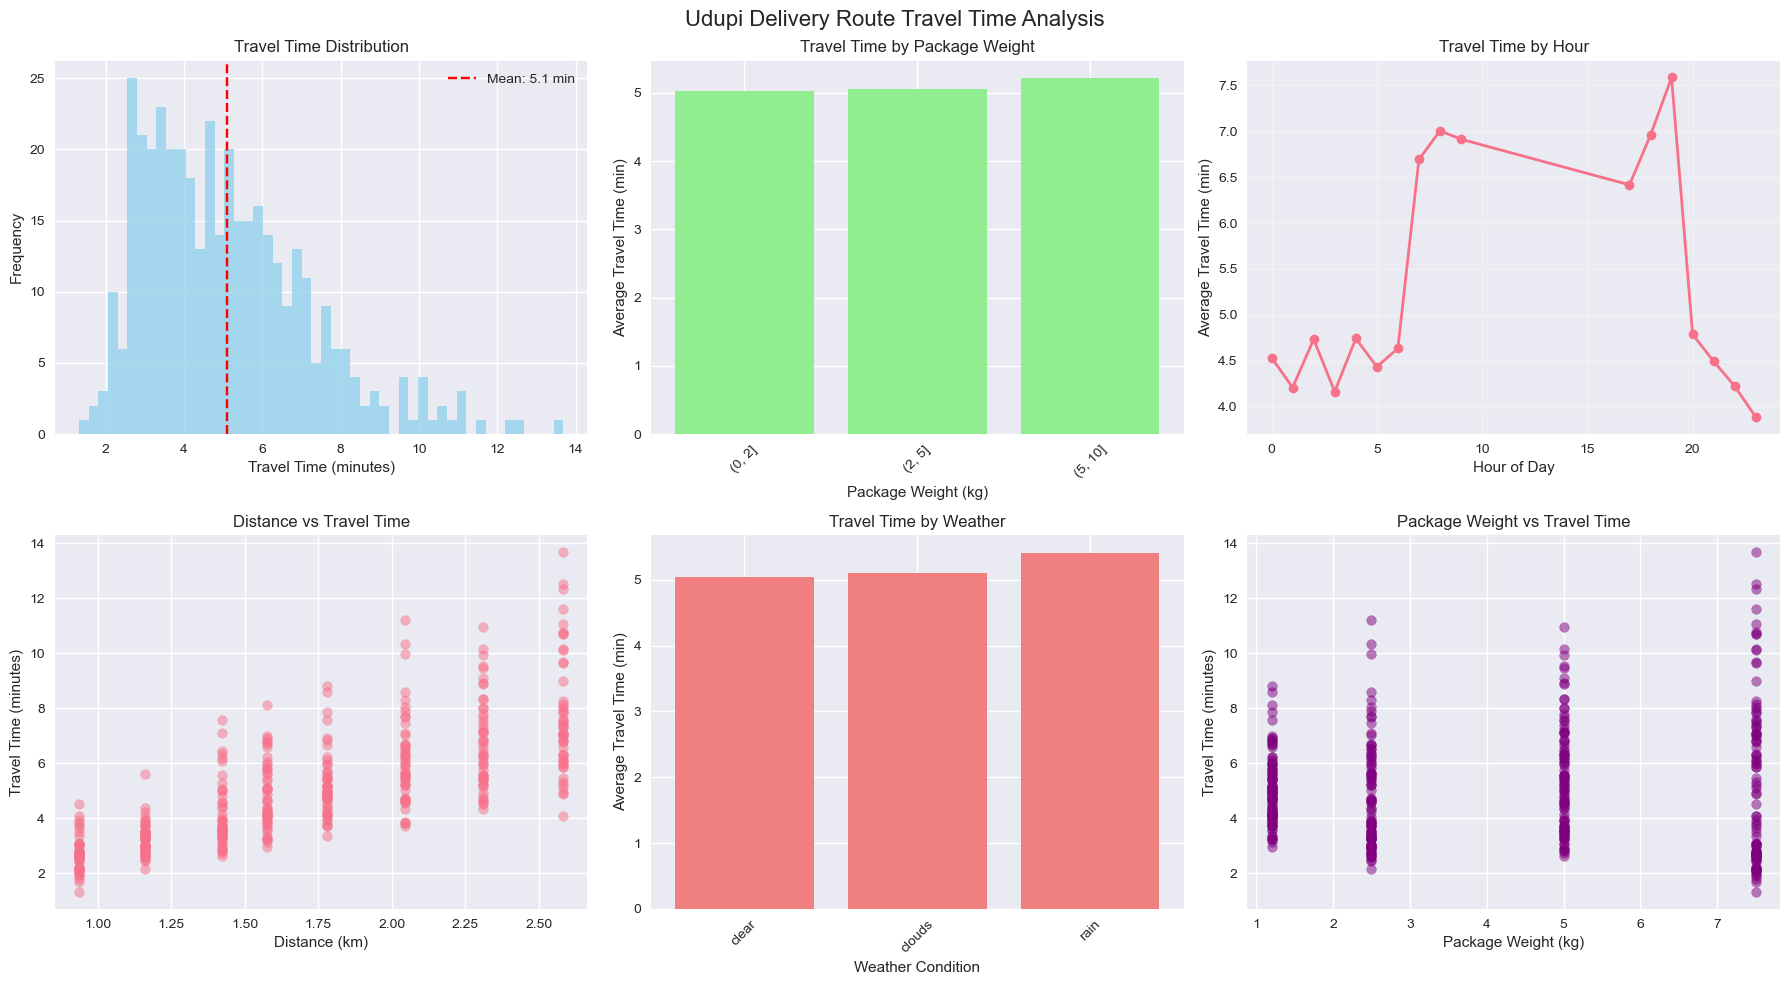

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Udupi Delivery Route Travel Time Analysis', fontsize=16)

# 1. Travel time distribution
axes[0, 0].hist(training_df['travel_time_minutes'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].axvline(training_df['travel_time_minutes'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {training_df["travel_time_minutes"].mean():.1f} min')
axes[0, 0].set_xlabel('Travel Time (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Travel Time Distribution')
axes[0, 0].legend()

# 2. Travel time by package weight
weight_bins = pd.cut(training_df['package_weight'], bins=[0, 2, 5, 10, 20])
weight_avg = training_df.groupby(weight_bins)['travel_time_minutes'].mean()
axes[0, 1].bar(weight_avg.index.astype(str), weight_avg.values, color='lightgreen')
axes[0, 1].set_xlabel('Package Weight (kg)')
axes[0, 1].set_ylabel('Average Travel Time (min)')
axes[0, 1].set_title('Travel Time by Package Weight')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Travel time by hour
hourly_avg = training_df.groupby('hour')['travel_time_minutes'].mean()
axes[0, 2].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0, 2].set_xlabel('Hour of Day')
axes[0, 2].set_ylabel('Average Travel Time (min)')
axes[0, 2].set_title('Travel Time by Hour')
axes[0, 2].grid(True, alpha=0.3)

# 4. Distance vs travel time
axes[1, 0].scatter(training_df['distance_km'], training_df['travel_time_minutes'], alpha=0.5)
axes[1, 0].set_xlabel('Distance (km)')
axes[1, 0].set_ylabel('Travel Time (minutes)')
axes[1, 0].set_title('Distance vs Travel Time')

# 5. Weather impact
weather_avg = training_df.groupby('weather_condition')['travel_time_minutes'].mean()
axes[1, 1].bar(weather_avg.index, weather_avg.values, color='lightcoral')
axes[1, 1].set_xlabel('Weather Condition')
axes[1, 1].set_ylabel('Average Travel Time (min)')
axes[1, 1].set_title('Travel Time by Weather')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Package weight vs travel time
axes[1, 2].scatter(training_df['package_weight'], training_df['travel_time_minutes'], alpha=0.5, color='purple')
axes[1, 2].set_xlabel('Package Weight (kg)')
axes[1, 2].set_ylabel('Travel Time (minutes)')
axes[1, 2].set_title('Package Weight vs Travel Time')

plt.tight_layout()
plt.show()

In [71]:
# Correlation analysis
print("\n Feature Correlations with Travel Time:")
correlations = training_df.corr()['travel_time_minutes'].sort_values(ascending=False)
for feature, corr in correlations.items():
    if feature != 'travel_time_minutes':
        print(f"   {feature:20s}: {corr:6.3f}")



 Feature Correlations with Travel Time:
   distance_km         :  0.762
   is_rush_hour        :  0.505
   lng_diff            :  0.230
   lat_diff            :  0.158
   weight_factor       :  0.107
   package_weight      :  0.074
   dest_lng            :  0.072
   month               :  0.062
   hour                :  0.061
   temperature         :  0.061
   dest_lat            :  0.041
   wind_speed          :  0.012
   humidity            :  0.004
   day_of_week         : -0.016
   visibility          : -0.028
   is_weekend          : -0.043
   center_lat          : -0.086
   center_lng          : -0.125
   route_id            : -0.197
   origin_lng          : -0.260
   origin_lat          : -0.260
   is_night            :    nan


### DATA PREPROCESSING

In [72]:
def preprocess_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, Dict]:
    """Preprocess the training data."""
    
    # Separate features and target
    X = df.drop(['travel_time_minutes', 'route_id'], axis=1)
    y = df['travel_time_minutes']
    
    print(f" Original features: {X.shape[1]}")
    
    # Handle categorical variables
    label_encoders = {}
    categorical_columns = ['weather_condition']
    
    for col in categorical_columns:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
            print(f"   Encoded {col}: {len(le.classes_)} categories")
    
    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X), 
        columns=X.columns, 
        index=X.index
    )
    
    print(f"  Scaled {X.shape[1]} numerical features")
    print(f" Target variable: {y.name} (shape: {y.shape})")
    
    return X_scaled, y, scaler, label_encoders


In [73]:
# Preprocess the data
X_processed, y_processed, feature_scaler, encoders = preprocess_data(training_df)

print(f"\n Processed Dataset Shape: {X_processed.shape}")
print(f" Feature Names: {list(X_processed.columns)}")

 Original features: 22
   Encoded weather_condition: 3 categories
  Scaled 22 numerical features
 Target variable: travel_time_minutes (shape: (400,))

 Processed Dataset Shape: (400, 22)
 Feature Names: ['origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'distance_km', 'center_lat', 'center_lng', 'lat_diff', 'lng_diff', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'is_night', 'temperature', 'humidity', 'weather_condition', 'wind_speed', 'visibility', 'package_weight', 'weight_factor']


### MODEL TRAINING AND COMPARISON


In [78]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=CONFIG['RANDOM_SEED']
)

print(f" Training set: {X_train.shape}")
print(f" Test set: {X_test.shape}")

# Define models to compare
models = {
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=CONFIG['RANDOM_SEED']
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=8,
        random_state=CONFIG['RANDOM_SEED']
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=CONFIG['RANDOM_SEED'],
        verbose=-1
    )
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                               scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'cv_mae': cv_mae,
        'predictions': y_pred_test
    }
    
    print(f"    {name} Results:")
    print(f"      • Train MAE: {train_mae:.2f} min")
    print(f"      • Test MAE:  {test_mae:.2f} min")
    print(f"      • Test RMSE: {test_rmse:.2f} min")
    print(f"      • Test R²:   {test_r2:.3f}")
    print(f"      • CV MAE:    {cv_mae:.2f} min")


 Training set: (320, 22)
 Test set: (80, 22)

 Training XGBoost...
    XGBoost Results:
      • Train MAE: 0.07 min
      • Test MAE:  0.69 min
      • Test RMSE: 0.95 min
      • Test R²:   0.799
      • CV MAE:    0.81 min

 Training Random Forest...
    Random Forest Results:
      • Train MAE: 0.31 min
      • Test MAE:  0.63 min
      • Test RMSE: 0.85 min
      • Test R²:   0.841
      • CV MAE:    0.74 min

 Training LightGBM...
    LightGBM Results:
      • Train MAE: 0.35 min
      • Test MAE:  0.63 min
      • Test RMSE: 0.80 min
      • Test R²:   0.858
      • CV MAE:    0.76 min


###  MODEL COMPARISON AND SELECTION

In [80]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MAE': [results[model]['test_mae'] for model in results.keys()],
    'Test RMSE': [results[model]['test_rmse'] for model in results.keys()],
    'Test R²': [results[model]['test_r2'] for model in results.keys()],
    'CV MAE': [results[model]['cv_mae'] for model in results.keys()]
})

print(" Model Comparison:")
print(comparison_df.round(3))

# Select best model based on test MAE
best_model_name = comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Model']
best_model = results[best_model_name]['model']

print(f"\n Best Model: {best_model_name}")
print(f"   • Test MAE: {results[best_model_name]['test_mae']:.2f} minutes")
print(f"   • Test R²: {results[best_model_name]['test_r2']:.3f}")

 Model Comparison:
           Model  Test MAE  Test RMSE  Test R²  CV MAE
0        XGBoost     0.693      0.953    0.799   0.810
1  Random Forest     0.634      0.850    0.841   0.742
2       LightGBM     0.626      0.803    0.858   0.759

 Best Model: LightGBM
   • Test MAE: 0.63 minutes
   • Test R²: 0.858


### MODEL ANALYSIS AND VISUALIZATION


 Top 10 Most Important Features:
   wind_speed          : 162.0000
   visibility          : 129.0000
   humidity            : 114.0000
   temperature         : 109.0000
   distance_km         : 107.0000
   hour                : 79.0000
   day_of_week         : 77.0000
   is_rush_hour        : 64.0000
   origin_lat          : 36.0000
   dest_lat            : 28.0000


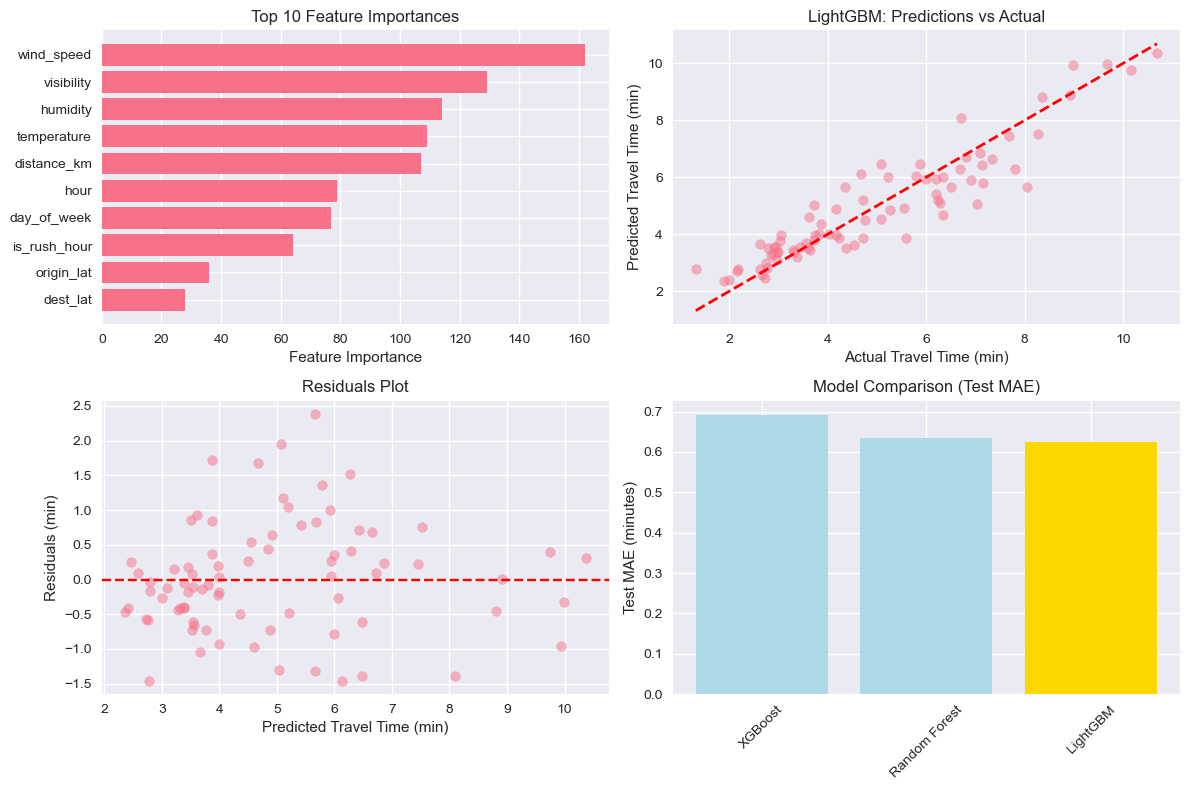

In [81]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_processed.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(" Top 10 Most Important Features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"   {row['feature']:20s}: {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()

# Prediction vs Actual plot
plt.subplot(2, 2, 2)
y_pred_best = results[best_model_name]['predictions']
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Travel Time (min)')
plt.ylabel('Predicted Travel Time (min)')
plt.title(f'{best_model_name}: Predictions vs Actual')

# Residuals plot
plt.subplot(2, 2, 3)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Travel Time (min)')
plt.ylabel('Residuals (min)')
plt.title('Residuals Plot')

# Model comparison
plt.subplot(2, 2, 4)
model_names = list(results.keys())
test_maes = [results[model]['test_mae'] for model in model_names]
plt.bar(model_names, test_maes, color=['gold' if model == best_model_name else 'lightblue' for model in model_names])
plt.ylabel('Test MAE (minutes)')
plt.title('Model Comparison (Test MAE)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


###  SAVE THE BEST MODEL


In [82]:
# Create model package
model_package = {
    'model': best_model,
    'scaler': feature_scaler,
    'label_encoders': encoders,
    'feature_columns': list(X_processed.columns),
    'model_name': best_model_name,
    'training_metrics': {
        'test_mae': results[best_model_name]['test_mae'],
        'test_rmse': results[best_model_name]['test_rmse'],
        'test_r2': results[best_model_name]['test_r2'],
        'cv_mae': results[best_model_name]['cv_mae']
    },
    'training_date': datetime.datetime.now().isoformat(),
    'training_samples': len(training_df),
    'feature_importance': feature_importance.to_dict('records') if hasattr(best_model, 'feature_importances_') else None
}

# Save model
model_filename = f'udupi_delivery_travel_time_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)
    
print(f" Model saved to '{model_filename}'")


 Model saved to 'udupi_delivery_travel_time_model.pkl'


###  PREDICTION FUNCTION


In [83]:
def predict_travel_time_for_delivery(delivery_data: Dict[str, Any], 
                                   model_package: Dict[str, Any]) -> Dict[str, Any]:
    """
    Predict travel times for all delivery person to delivery combinations.
    
    Args:
        delivery_data: The input delivery data in the specified format
        model_package: The saved model package
        
    Returns:
        Dictionary with predictions for all combinations
    """
    print("\n" + "=" * 60)
    print("MAKING PREDICTIONS FOR DELIVERY DATA")
    print("=" * 60)
    
    # Extract components from model package
    model = model_package['model']
    scaler = model_package['scaler']
    label_encoders = model_package['label_encoders']
    feature_columns = model_package['feature_columns']
    
    # Prepare prediction data
    prediction_data = []
    prediction_metadata = []
    
    current_time = datetime.datetime.fromisoformat(delivery_data['current_time'])
    
    for dp in delivery_data['delivery_persons']:
        for delivery in delivery_data['deliveries']:
            # Get weather data
            weather_data = get_weather_data(
                dp['location']['lat'], dp['location']['lng'],
                current_time, CONFIG['WEATHER_API_KEY']
            )
            
            # Create features
            features = create_features(
                dp['location']['lat'], dp['location']['lng'],
                delivery['location']['lat'], delivery['location']['lng'],
                current_time, weather_data,
                delivery['package_details']['weight']
            )
            
            # Store metadata for reference
            prediction_metadata.append({
                'delivery_person_id': dp['id'],
                'delivery_id': delivery['id'],
                'origin_lat': dp['location']['lat'],
                'origin_lng': dp['location']['lng'],
                'dest_lat': delivery['location']['lat'],
                'dest_lng': delivery['location']['lng'],
                'package_weight': delivery['package_details']['weight']
            })
            
            prediction_data.append(features)
    
    # Convert to DataFrame
    prediction_df = pd.DataFrame(prediction_data)
    
    # Preprocess the data (same as training)
    X_pred = prediction_df[feature_columns]
    
    # Encode categorical variables
    for col, encoder in label_encoders.items():
        X_pred[col] = encoder.transform(X_pred[col].astype(str))
    
    # Scale numerical features
    X_pred_scaled = pd.DataFrame(
        scaler.transform(X_pred), 
        columns=X_pred.columns, 
        index=X_pred.index
    )
    
    # Make predictions
    predictions = model.predict(X_pred_scaled)
    
    # Combine results with metadata
    results = []
    for i, pred in enumerate(predictions):
        results.append({
            **prediction_metadata[i],
            'predicted_travel_time_minutes': float(pred)
        })
    
    # Format output similar to the example
    output = {
        "data": {
            "predictions": results
        }
    }
      
    print(f" Generated {len(predictions)} predictions")
    return output

# Test the prediction function
print("\nTesting prediction function with sample delivery data...")
predictions = predict_travel_time_for_delivery(SAMPLE_DELIVERY_DATA, model_package)

# Print sample predictions
print("\nSample predictions:")
print(json.dumps(predictions, indent=2))


Testing prediction function with sample delivery data...

MAKING PREDICTIONS FOR DELIVERY DATA
 Generated 8 predictions

Sample predictions:
{
  "data": {
    "predictions": [
      {
        "delivery_person_id": "dp1",
        "delivery_id": "del1",
        "origin_lat": 13.3409,
        "origin_lng": 74.7421,
        "dest_lat": 13.3512,
        "dest_lng": 74.7403,
        "package_weight": 2.5,
        "predicted_travel_time_minutes": 3.698585491018404
      },
      {
        "delivery_person_id": "dp1",
        "delivery_id": "del2",
        "origin_lat": 13.3409,
        "origin_lng": 74.7421,
        "dest_lat": 13.3601,
        "dest_lng": 74.7501,
        "package_weight": 5.0,
        "predicted_travel_time_minutes": 8.229801354456876
      },
      {
        "delivery_person_id": "dp1",
        "delivery_id": "del3",
        "origin_lat": 13.3409,
        "origin_lng": 74.7421,
        "dest_lat": 13.335,
        "dest_lng": 74.755,
        "package_weight": 1.2,
        